In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import keras
from tensorflow.keras.models  import Model,Sequential
from keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout,TimeDistributed,Masking
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
from clr_callback import *
import numpy.ma as ma
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Output labels to to classify dance sequence
LABELS = ["gojjam","guragingna","shoa"]
#dataset path
pathDS = "../dataset/data/"
#number of feautres
features = 36 
#number of labels
classes = 3
#batchSize = 
batchSize = 100

In [3]:
#load training data
x = []
y = []

def loadTrainingXY(data):
    sequenceSize = 50
    
    prevStep = 0
    currentArray = []
    
    for i in range(len(data)):
        if(i != 0):
            prevStep = data[i-1][36]
        currentStep = data[i][36]
    
        if( i != 0 and currentStep <= prevStep):
            
            if(len(currentArray) >= 20):
            
                currentArray = np.array(currentArray).astype(np.float32)
                
                #normalize data
                '''for inorm in range(36):
                    
                    temp = currentArray[:,inorm]
                    maxV = np.nanmax(temp)
                    minV = np.nanmin(temp)
                    
                    if(str(maxV) != str('nan') and str(minV) != str('nan')):
                        tempV = (temp-np.nanmin(temp))/(np.nanmax(temp)-np.nanmin(temp))
                        currentArray[:,inorm] = tempV'''
                        
                
                currentArray = np.where(np.isnan(currentArray), ma.array(currentArray, mask=np.isnan(currentArray)).mean(axis=0), currentArray)
               
            '''if(prevStep >=5):
            
                x.append(np.array(currentArray).astype(np.float32))
                y.append(LABELS.index(data[i-1][37]))'''
            if(len(currentArray) >= sequenceSize):

                nI = sequenceSize
                pI = 0
                for j in range(len(currentArray)// sequenceSize):
                    x.append(np.array(currentArray[pI:nI]).astype(np.float32))
                    y.append(LABELS.index(data[i-1][37]))
                    
                    nI += sequenceSize
                    pI += sequenceSize 
            
            else:
                if(len(currentArray) >= 20 and len(currentArray) < sequenceSize):
                    padding = np.zeros((36,), dtype=np.float32)
                    lengArray = len(currentArray)
                    for ip in range(sequenceSize + 1):
                        
                        if(lengArray >= ip):
                            continue
                        else:
                            
                            currentArray = np.append(currentArray,[padding],axis=0)
                    x.append(np.array(currentArray).astype(np.float32))
                    y.append(LABELS.index(data[i-1][37]))                  
    
            currentArray = []
            currentArray.clear()

        currentArray.append(np.array(data[i][:36]).astype(np.float32)) 

In [4]:
csvFile = [csv for csv in os.listdir(pathDS)]
pdList = []
for file in csvFile:
    
    data=pd.read_csv(pathDS+str(file),header=None)
    pdList.append(data)

# Stack the DataFrames on top of each other
data = pd.concat(pdList, axis=0)
data.iloc[:,0:36] = data.iloc[:,0:36].replace(0, np.nan)
data.iloc[:,0:36] = data.iloc[:,0:36].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
testDD = loadTrainingXY(data.values)
    

In [5]:
data

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,-1.051093,-2.056320,-1.003195,-1.755186,-1.020822,-1.724891,-1.035060,-1.451960,-1.293697,-1.665984,...,-1.065819,-2.112631,-1.033526,-2.106905,-1.052420,-2.029370,-1.049487,-2.059145,0.0,shoa
1,-1.051093,-2.056320,-1.003195,-1.755186,-1.020822,-1.724891,-1.041912,-1.451960,-1.293697,-1.665984,...,-1.065819,-2.112631,-1.033526,-2.106905,-1.052420,-2.029370,-1.049487,-2.059145,1.0,shoa
2,-1.044200,-2.026354,-1.003195,-1.723654,-1.020822,-1.724891,-1.083027,-1.451960,-1.334737,-1.665984,...,-1.065819,-1.903764,-1.026627,-2.076879,-1.052420,-1.845814,-1.049487,-2.059145,2.0,shoa
3,-1.044200,-1.996389,-1.044471,-1.723654,-1.055095,-1.724891,-1.089879,-1.451960,-1.341577,-1.665984,...,-1.065819,-1.903764,-1.026627,-1.896725,-1.045451,-1.815222,-1.049487,-1.996780,3.0,shoa
4,-1.044200,-1.996389,-1.051350,-1.723654,-1.068804,-1.535786,-1.096732,-1.451960,-1.348416,-1.665984,...,-1.065819,-1.903764,-1.026627,-1.896725,-1.045451,-1.815222,-1.049487,-1.809683,4.0,shoa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51924,0.885767,-0.887668,0.867978,-1.250674,0.864180,-1.252129,0.897340,-1.451960,0.949797,-1.665984,...,0.881611,-0.919104,0.863819,-0.935903,0.954688,-0.866850,0.839214,-0.843020,50.0,guragingna
51925,0.885767,-0.887668,0.867978,-1.250674,0.864180,-1.252129,0.890487,-1.483099,NaN,NaN,...,0.874705,-0.948942,0.863819,-0.935903,0.947719,-0.866850,0.832296,-0.874203,51.0,guragingna
51926,0.885767,-0.887668,0.833581,-1.250674,0.864180,-1.252129,0.897340,-1.669938,0.901918,-1.878036,...,0.874705,-0.919104,0.856919,-0.905877,0.912873,-0.866850,0.797704,-0.843020,52.0,guragingna
51927,0.844411,-0.887668,0.826702,-1.219142,0.864180,-1.220611,0.945307,-1.451960,0.942957,-1.665984,...,0.874705,-0.769914,0.856919,-0.905877,0.905904,-0.836257,0.790786,-0.843020,53.0,guragingna


In [6]:
xDataSet = np.array(x).astype(np.float32)
'''
le = LabelEncoder()
le.fit(y)

yDataSet = le.transform(y)
'''
yDataSet = np.array(y).astype(np.float32)
#test train split
X_train, X_test, y_train, y_test = train_test_split(xDataSet, yDataSet, test_size=0.3)

y_test = keras.utils.to_categorical(y_test,num_classes=3)
y_train = keras.utils.to_categorical(y_train,num_classes=3)

In [8]:
#defining LTSM model
model = Sequential([
   Masking(mask_value=0.,input_shape=(50, 36)),
   Dense(features, activation='relu'),
   LSTM(features, return_sequences=True,  unit_forget_bias=1.0,dropout=0.1),
   LSTM(features, unit_forget_bias=1.0),
   Dense(3,activation='softmax'
   )
])

2021-10-30 23:35:41.074718: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-30 23:35:41.089276: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-30 23:35:41.188539: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
model.compile(
   optimizer="adam",
   metrics=['accuracy'],
   loss='categorical_crossentropy')

In [10]:
history = model.fit(
   X_train, 
   y_train, 
   epochs=50,
   batch_size=50,
   validation_data=(X_test, y_test)
)


2021-10-30 23:35:49.591321: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-30 23:35:49.687194: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2394515000 Hz


Epoch 1/50
21/21 [==============================] - 21s 544ms/step - loss: 1.0022 - accuracy: 0.5118 - val_loss: 0.7770 - val_accuracy: 0.6713
Epoch 2/50
21/21 [==============================] - 10s 454ms/step - loss: 0.7706 - accuracy: 0.6584 - val_loss: 0.7175 - val_accuracy: 0.6946
Epoch 3/50
21/21 [==============================] - 7s 337ms/step - loss: 0.6674 - accuracy: 0.7281 - val_loss: 0.6696 - val_accuracy: 0.7319
Epoch 4/50
21/21 [==============================] - 9s 441ms/step - loss: 0.5747 - accuracy: 0.7691 - val_loss: 0.7154 - val_accuracy: 0.7086
Epoch 5/50
21/21 [==============================] - 7s 334ms/step - loss: 0.6243 - accuracy: 0.7476 - val_loss: 0.5626 - val_accuracy: 0.7809
Epoch 6/50
21/21 [==============================] - 7s 346ms/step - loss: 0.5803 - accuracy: 0.7633 - val_loss: 0.5736 - val_accuracy: 0.7716
Epoch 7/50
21/21 [==============================] - 6s 274ms/step - loss: 0.5146 - accuracy: 0.8238 - val_loss: 0.5391 - val_accuracy: 0.7902
Epoc

In [11]:
model.save('../models/model.h5')
model.save_weights('../models/weights.h5')

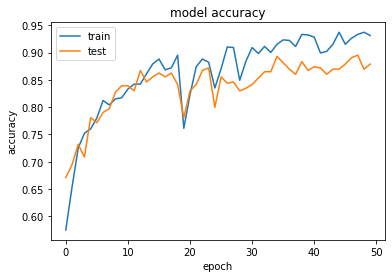

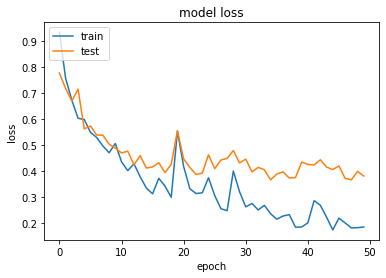

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()